# Bias Removal

Climate models can have biases relative to different verification datasets. Commonly, biases are removed by postprocessing before verification of forecasting skill. `climpred` provides convenience functions to do so.

In [1]:
import climpred
import xarray as xr
import matplotlib.pyplot as plt
from climpred import HindcastEnsemble

In [2]:
hind = climpred.tutorial.load_dataset('CESM-DP-SST') # CESM-DPLE hindcast ensemble output.
recon = climpred.tutorial.load_dataset('FOSI-SST') # Reconstruction simulation that initialized CESM-DPLE.
hind["lead"].attrs["units"] = "years"

We begin by removing a mean climatology for the reconstruction, since `CESM-DPLE` generates its anomalies over this same time period.

In [3]:
recon = recon - recon.sel(time=slice('1964', '2014')).mean('time')

/Users/rileybrady/Desktop/dev/climpred/climpred/utils.py:141: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  "Assuming annual resolution due to numeric inits. "


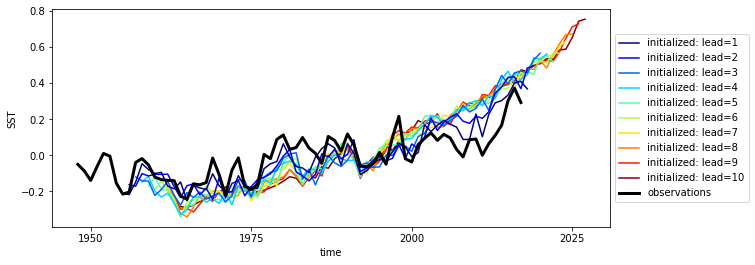

In [4]:
hindcast = HindcastEnsemble(hind)
hindcast = hindcast.add_observations(recon)
hindcast.plot()

The warming of the `reconstruction` is less than the `initialized`.

## Mean bias removal

Typically, bias depends on lead-time and therefore should therefore also be removed depending on lead-time.

In [5]:
bias = hindcast.verify(metric='bias', comparison='e2o', dim=[], alignment='same_verifs')

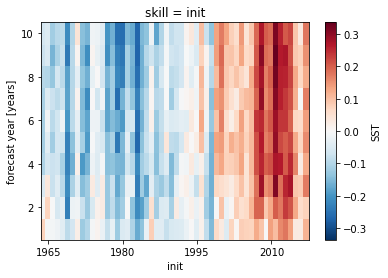

In [6]:
bias.SST.plot()

Against `reconstruction`, there is a cold bias in early initialization years and warm bias in later years.

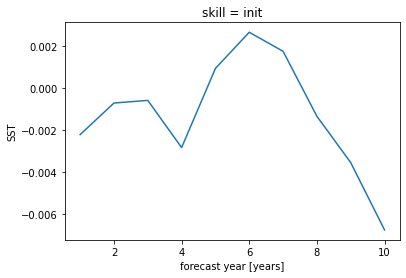

In [7]:
# lead-time dependant mean bias over all initializations is quite small
mean_bias = bias.mean('init')
mean_bias.SST.plot()

### Cross Validatation
To remove the mean bias quickly, the mean bias over all initializations is subtracted. For formally correct bias removal with cross validation, the given initialization is left out when subtracting the mean bias.

`climpred` wraps these functions in `HindcastEnsemble.remove_bias(how='mean', cross_validate={bool})`.

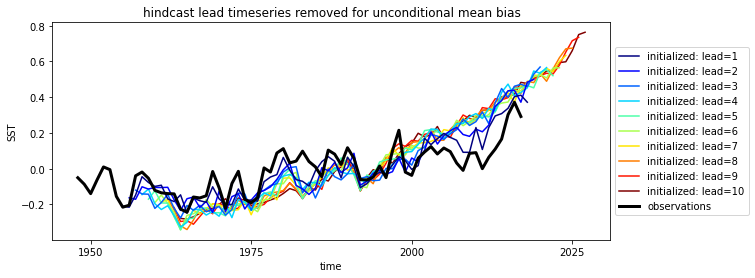

In [8]:
hindcast.remove_bias(how='mean', cross_validate=True, alignment='same_verifs').plot()
plt.title('hindcast lead timeseries removed for unconditional mean bias')
plt.show()

## Skill

Distance-based accuracy metrics like (`mse`,`rmse`,`nrmse`,...) are sensitive to mean bias removal. Correlations like (`pearson_r`, `spearman_r`) are insensitive to bias correction.

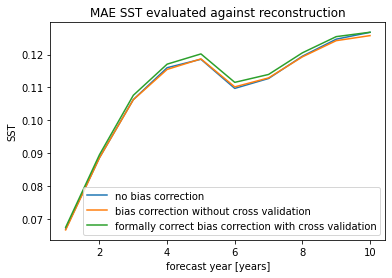

In [9]:
hindcast.verify(metric='mae',
                comparison='e2o',
                dim='init',
                alignment='same_verifs')['SST'].plot(label='no bias correction')
hindcast.remove_bias(cross_validate=False,
                     alignment='same_verifs') \
        .verify(metric='mae',
                comparison='e2o',
                dim='init',
                alignment='same_verifs').SST.plot(label='bias correction without cross validation')
hindcast.remove_bias(cross_validate=True,
                     alignment='same_verifs') \
        .verify(metric='mae',
                comparison='e2o',
                dim='init',
                alignment='same_verifs').SST.plot(label='formally correct bias correction with cross validation')
plt.legend()
plt.title(f"MAE SST evaluated against reconstruction")
plt.show()